# Methods in Bioinformatics, Homework 1 for Computer Science Students, 2025/26

## Introduction
In this homework, your task is to implement and evaluate algorithms for comparing two genomes based on their sets of $k$-mers. Tasks 1 and 2 ask you to implement several techniques covered in [Tutorial 5](https://fmfi-compbio.github.io/mbi/notes/ci-aln2-en.html) for CS students. The remaining tasks ask you to observe the behavior of these techniques in terms of accuracy, running time and memory on real and simulated data.

If you want to read more about the concepts from this homework, check these sources
* Jaccard index: https://en.wikipedia.org/wiki/Jaccard_index, https://www.statology.org/jaccard-similarity/
* Minimizers: https://homolog.us/blogs/bioinfo/2017/10/25/intro-minimizer/

## Use of AI and other sources

* As per [course rules](https://fmfi-compbio.github.io/mbi/Rules.html#academic-integrity) you are allowed to discuss the homework with other people in general terms, but all your code and texts should be **your own work**. In the bonus version of task 2.1 you are allowed to research the algorithm in existing sources as explained below.  In **tasks 1 and 2 do not use AI to generate your code, switch off AI assistant** in your working environment (e.g. in Google Colab, in the main menu Tools -> Settings -> AI assistence -> Hide generative AI features). In tasks 3-6 you may use AI to help with setting up appropriate plots and tables, but if you do, acknowledge such help in comments in your code and make sure that the code is correct. Your discussion should be written in your own words, do not generate it using AI.   


## Technical requirements and recommendations

* This notebook contains the task description, some useful helper functions, as well as some code to test your implementation in Tasks 1 and 2. Please do not modify the provided code and write your code in the indicated space. Run all cells, included those with our code.
* In your code for tasks 1-2, use only libraries already imported in the provided code and functions provided by us, such as `canonical` and `kmer_hash`.
* In tasks 3-6 you may use also other libraries. Measure all required quantities in the notebook and preferably also visualize them directly there. If you strongly prefer, you can create final visualizations in another system and submit this notebook as well as a separate pdf file with visualization and discussion.
* Your notebook should be executable on Google Colab. If you use any libraries not available on Colab by default, install them using `pip install` commands included in the notebook (section Libraries for tasks 3-6). If you use a different environment to develop your code, test it in Colab before submitting.
* To avoid running out of memory, we recommend deleting variables that are no longer needed using `del` and occasionally calling `gc.collect()` to run garbage collection and free unused memory.
* Some computations may take a long time to run. Leave sufficient time for finish the assignment. If the computation takes too long, you may try to improve your implementation.


## Submitting

* Submit the notebook with your code as an ipynb file. All cells should be executed with output shown.
* Tasks 3-6 ask you to make some measurements, summarize them in tables or plots and discuss your results. Include all these visualizations and discussion directly in this notebook.
* Text parts of the homework can be written in English or Slovak. The individual plots and tables should be properly annotated (axis labels, legends and titles or captions).

## Module imports (do not modify)

Use only modules listed below in parts 1 and 2. The code below uses pip command to install the Biopython library. If you have this library installed, you can comment out the line starting `!pip`.

In [4]:
# imports
import io
import os
import re
import gc
import sys
import random
import hashlib  #!!
from sklearn.utils import murmurhash3_32
import time
# numba library can precompile and speed up your code
from numba import njit

# libraries potentially useful in parts 1 and 2
import heapq
import itertools
from collections import deque
from collections.abc import Callable

# biopython library is used for parsing the input file
# The line below installs it. You may comment out this line
# if it is already installed in your environment.
!pip install biopython
from Bio import SeqIO

## Function definitions (do not modify)

We provide the following functions for you to use in your code:
* Function `canonical` returns the *canonical* version of an input $k$-mer defined as follows. For a $k$-mer $w$, let $w’$ be its reverse complement (obtained by reversing the string and exchanging complementary bases A<->T, C<->G). The canonical $k$-mer $w$ is then the smaller of $w$ and $w’$ in the lexicographic (alphabetical) order. For example, 4-mer CACT has reverse complement AGTG, which happens to be lexicographically smaller than CACT, and thus it is its canonical version.
* Function `full_kmer_set` gets a string consisting of letters A,C,G,T representing a single genome and integer `k` and returns a Python set of all canonical $k$-mers of the input string. Canonical $k$-mers help us to represent both strands of the DNA molecule (the genome and its reverse complement will produce the same set of canonical $k$-mers).
* Function `kmer_hash` computes a hash value for a $k$-mer. Use it for minimizer computations.
* Function `debug_hash` is a simple hash function which simply encodes a k-mer as a number. Use to debug your minimizer code.

In [5]:
@njit
def c(x: str) -> str:
    """Returns complement of a single DNA base"""
    if x == 'A':
        return 'T'
    elif x == 'T':
        return 'A'
    elif x == 'C':
        return 'G'
    elif x == 'G':
        return 'C'
    else:
        return ""


@njit
def _reverse_complement(seq: str) -> str:
    """Returns reverse complement (opposite strand) of a DNA sequence"""
    return "".join([c(seq[i]) for i in range(len(seq) - 1, -1, -1)])


@njit
def canonical(kmer: str) -> str:
    """Returns a canonical k-mer for the input k-mer. """
    comp_kmer = _reverse_complement(kmer)
    if kmer <= comp_kmer:
        return kmer
    else:
        return comp_kmer


@njit
def full_kmer_set(sequence: str, k: int) -> set[str]:
    """Function gets a string consisting of letters A,C,G,T representing a single genome
    and integer k and returns a Python set of all canonical k-mers of the input string."""
    result = set()
    for start in range(len(sequence) - k + 1):
        result.add(canonical(sequence[start:start + k]))
    return result


def kmer_hash(seq: str) -> int:
    """A hash function to be used for hashing k-mers in minimizers and MinHash"""
    return murmurhash3_32(seq, seed=1)


def debug_hash(seq: str) -> int:
    """A simple hash function which encodes DNA as a base-4 number
    with A being digit 0, C 1, G 2, T 3. This is to be used for debugging minimizers"""
    base2num = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    result = 0
    for base in seq:
        result = result * 4 + base2num[base]
    return result


# testing
print(f"{[x + '->' + c(x) for x in 'ACGT']}")
print(f"{_reverse_complement('AGTG')=}")
print(f"{_reverse_complement('CACT')=}")
print(f"{canonical('AGTG')=}")
print(f"{canonical('CACT')=}")
print(f"{list(full_kmer_set('CCAAGGTCCATC', k=3))=}")
print(f"{kmer_hash('A' * 13)=}, {kmer_hash('ACTACTACTACTG')=} {kmer_hash('T'*12 + 'A')=}")
print(f"{debug_hash('AAA')=}, {debug_hash('AAG')=}, {debug_hash('CAA')=}, {debug_hash('TTT')=}")

['A->T', 'C->G', 'G->C', 'T->A']
_reverse_complement('AGTG')='CACT'
_reverse_complement('CACT')='AGTG'
canonical('AGTG')='AGTG'
canonical('CACT')='AGTG'
list(full_kmer_set('CCAAGGTCCATC', k=3))=['GGA', 'CAA', 'AGG', 'ATC', 'ATG', 'GAC', 'ACC', 'CCA', 'AAG']
kmer_hash('A' * 13)=1280048192, kmer_hash('ACTACTACTACTG')=-591269436 kmer_hash('T'*12 + 'A')=-1519362212
debug_hash('AAA')=0, debug_hash('AAG')=2, debug_hash('CAA')=16, debug_hash('TTT')=63


## Downloading genomes (do not modify)

This part downloads some real genomes as follows.

* It uses `read_fasta` function to download a file from URL `http://compbio.fmph.uniba.sk/vyuka/mbi-data/du1/bacteria.fasta`. This file contains several bacterial genomes in the FASTA format. The function returns two lists stored in variables `real_genomes` and `real_genome_descriptions`.
  * The first variable is a list of strings consisting of letters A,C,G,T. (Some of these genomes contain unknown bases denoted as N; these are for simplicity omitted.)
  * The second variable is a list of strings of the same length containing a text description of the sequence and its identifier from the RefSeq database.
* We will refer to these genomes by numbers $0,1,\dots$ based on their index in the two lists.
* When you run this cell for the first time, the sequences will be downloaded from the internet and saved to `bacteria.fasta` file. Subsequently, this file will be read instead.


In [6]:
def read_fasta(url=None, filename=None):
    """Function reads sequences in a FASTA format and returns them as a list of strings consisting of letters A,C,G,T.
    It also returns a list of descriptions of these sequences. If filename is given and it exists,
    sequences are read from the file. Otherwise they are read from the URL and written to the file."""

    # open file or url
    handle = None
    output_handle = None
    if filename is not None and os.path.isfile(filename) \
            and os.path.getsize(filename) > 0:
        handle = open(filename, 'r')
    elif url is not None:
        from urllib.request import urlopen
        handle = io.TextIOWrapper(urlopen(url), encoding='utf-8')
        if filename is not None:
            output_handle = open(filename, "w")

    real_genomes, real_genome_descriptions = [], []
    for gnum, genome in enumerate(SeqIO.parse(handle, "fasta")):
        if output_handle is not None:
            SeqIO.write(genome, output_handle, "fasta")
        sequence = str(genome.seq).replace('N', '')
        if not re.match(r'\A[ACGT]+\Z', sequence):
            raise ValueError(f"Bad genome characters in the input file")
        description = genome.description
        real_genomes.append(sequence)
        real_genome_descriptions.append(description)
        print(f"Parsed genome #{gnum}: {description[:70]}...", file=sys.stderr)

    if output_handle is not None:
        output_handle.close()
    handle.close()

    return real_genomes, real_genome_descriptions


start = time.time()
url = "http://compbio.fmph.uniba.sk/vyuka/mbi-data/du1/bacteria.fasta"
real_genomes, real_genome_descriptions = read_fasta(url=url, filename="bacteria.fasta")
if len(real_genomes) != 9:
    raise Exception("Some problem with reading sequences, perhaps delete bacteria.fasta file")
gc.collect()
end = time.time()
print(f"Downloading genomes took {end - start} seconds")

Parsed genome #0: NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome...
Parsed genome #1: NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, co...
Parsed genome #2: NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, ...
Parsed genome #3: NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, ...
Parsed genome #4: NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome...
Parsed genome #5: NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome...
Parsed genome #6: NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete ...
Parsed genome #7: NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, comple...
Parsed genome #8: NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, c...


## Creating mutated genomes (do not modify)

This part will create some artificially mutated versions of genome 0 downloaded in the previous section.
* Function `mutate` gets a string consisting of letters A,C,G,T representing a single genome and a mutation probability $p$ (a real number between 0 and 1). For each base
of the input string it mutates it with probability $p$ and leaves it as it was with probability $1-p$. If the base is mutated, it is replaced by a randomly chosen base from the remaining three.
* We create artificially mutated versions of genome 0 with mutation probabilities $p$=0.01, 0.05, 0.1, 0.2, 0.3, 0.4. As a result you have 6 new genomes stored in list `mutated_genomes`. The corresponding values of $p$ are in list `mutation_probabilities`.
* To make the results reproducible, we set random seed to 47. Do not change this value.

In [7]:
@njit
def mutate(sequence: str, p: float) -> str:
    """Function gets a string consisting of letters A,C,G,T representing a single genome and a mutation probability p (a real number between 0 and 1).
    For each base of the input string it will decide with probability p to mutate it or 1-p to leave it as it was.
    If the base is mutated, it is replaced by a randomly chosen base from the remaining three."""
    others = {x: "ACGT".replace(x, "") for x in "ACGT"}
    result = "".join([x if random.random() > p else others[x][random.randint(0, 2)] for x in sequence])
    return result


# testing function
print(f"{[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=}")

# creating needed variables
mutation_probabilities = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
random.seed(47)
mutated_genomes = [mutate(real_genomes[0], p) for p in mutation_probabilities]
gc.collect()

[mutate('AAAACCCCGGGGTTTT', p=0.25) for _ in range(5)]=['ATAACCCCGGGGGTTT', 'AAAACCACGGGGTTTG', 'ACAATCCCCGTGTTTG', 'GAAACCGCGGGGTTGT', 'GAACCCCCGGGGTTTT']


9751

## Task 1: Jaccard similarity

In this task, we write functions for comparing two DNA sequences based on the Jaccard similarity of their sets of canonical $k$-mers. More similar sequence typically have a higher Jaccard similarity (more on this in Task 4).

### Task 1.1: Implement function `jaccard`

Implement function `jaccard` which gets two sets and computes their Jaccard similarity by considering the sizes of their intersection and union. You can assume that the union of the two sets is non-empty.

In [8]:
def jaccard(first_set: set[str], second_set: set[str]) -> float:
    return len(first_set & second_set) / len(first_set | second_set)


### Task 1.2: Implement function `kmer_jaccard`

Implement function `kmer_jaccard` which gets one DNA sequence, a list of $n$ DNA sequences and a value of `k`, converts all sequences to k-mer sets using provided function `full_kmer_set` and computes a list of $n$ Jaccard similarities of the first sequence compared each of the sequences in the list. You can assume that all sequences have the length at least $k$.

In [9]:
def kmer_jaccard(first_sequence: str, sequence_list: list[str], k: int) -> list[float]:
    first_set = full_kmer_set(first_sequence, k)
    return [jaccard(first_set, full_kmer_set(seq, k)) for seq in sequence_list]

### Task 1.3: Test your code on small tests

Run your function on the small debugging inputs below and check if the answers are correct. Do not modify the tests, but you can add more of them.

In [10]:
setA = {'abc'}
setB = {'bb'}
setAB = {'abc', 'bb'}
setABC = {'abc', 'bb', 'cde'}
print(f"{jaccard(setA, setA)=} (should be {1.0})")
print(f"{jaccard(setA, setB)=} (should be {0.0})")
print(f"{jaccard(setA, setAB)=} (should be {1 / 2})")
print(f"{jaccard(setA, setABC)=} (should be {1 / 3})")
print(f"{jaccard(setAB, setA)=} (should be {1 / 2})")
print(f"{jaccard(setAB, setABC)=} (should be {2 / 3})")

seq1 = "AAACCC"
seq2 = "GGGTTT"  # reverse complement of seq1, identical set of canonical k-mers
seq3 = "AAAGTG"
seq4 = "ACAC"
print(f"{kmer_jaccard(seq1, [seq1, seq2, seq3, seq4], 3)=}")
print(f"  results should be {[1.0, 1.0, 1 / 7, 0.0]}")

jaccard(setA, setA)=1.0 (should be 1.0)
jaccard(setA, setB)=0.0 (should be 0.0)
jaccard(setA, setAB)=0.5 (should be 0.5)
jaccard(setA, setABC)=0.3333333333333333 (should be 0.3333333333333333)
jaccard(setAB, setA)=0.5 (should be 0.5)
jaccard(setAB, setABC)=0.6666666666666666 (should be 0.6666666666666666)
kmer_jaccard(seq1, [seq1, seq2, seq3, seq4], 3)=[1.0, 1.0, 0.14285714285714285, 0.0]
  results should be [1.0, 1.0, 0.14285714285714285, 0.0]


## Task 2: Minimizers

In this task we write an alternative way of comparing two sequences using Jaccard similarity of their sets of minimizers instead of all $k$-mers. The set of minimizers is potentially smaller, thus saving time and memory if many sets are compared to each other.


### Task 2.1 Implement function `minimizer_set`

Implement function `minimizer_set` which gets a string consisting of letters A,C,G,T, two parameters `k` and `s` and hash function `h`. For each sliding window of `s` consecutive `k`-mers, it computes the canonical versions of these $k$-mers, applies function `h` on each canonical $k$-mer, chooses the canonical $k$-mer with the smallest hash value and stores this $k$-mer in the set. You can assume that the length of the sequence is at least $k-s+1$.

For example let $k=2$, $s=3$ and we use the `debug_hash` to find minimizers for sequence 'AAGGG'.  We first take first three $2$-mers 'AA', 'AG', 'GG'. Their canonical versions are 'AA', 'AG', 'CC'. Their hash values are  0, 2, and 5. The minimum is 0 corresponding to canonical $k$-mer 'AA'. The next sliding window has canonical $k$-mers 'AG', 'CC', 'CC' with hash values 2, 5, 5. Now canonical $k$-mer 'AG' is the minimizer. The resulting set will be therefore {'AA', 'AG'}.

The running time of your function on a sequence of length $n$ should be at most $O(n(k+s))$ assuming that a hash function and canonical version of one $k$-mer can be computed in $O(k)$ time. For bonus points you can try to implement a more efficient version running in $O(n(k+\log s))$ time or even $O(nk)$ time. You can try to find the $O(nk)$ time algorithm by searching in literature / on the internet, if you wish, but cite your source. You should understand the algorithm, implement it in your own code and explain it in your own words below.

Data structures `heapq` or `deque` from the Python standard library may be useful in the bonus version (and are imported above). Note that `heapq` does not support removing arbitrary elements efficiently, but you can temporarily keep invalid elements in the heap and remove them in an amortized way.

In [118]:
def minimizer_set(sequence: str, k: int, s: int,
                  h: Callable[[str], int]) -> set[str]:
    if len(sequence) < k + s - 1 or k < 1 or s < 1:
        raise ValueError("Sequence must have length at least k + s -1 for k>=1, s>=1.")

    min_set = set()
    n = len(sequence)

    hashes_pairs = [(canonical(sequence[i:i+k]),
                     h(canonical(sequence[i:i+k]))) for i in range(n - k + 1)]

    for start in range(0, n - k - (s - 1) + 1):
        window = hashes_pairs[start:start + s]
        min_set.add(
            min(window, key=lambda x: x[1])[0]
        )

    return min_set

### Task 2.2 Algorithm and its running time

Briefly explain the algorithm used by your function above and what is its running time in terms of $n$, $k$ and $s$. Write your explanation directly here.

We use naїve approach: we precompute hash for every k-mer, and then for every sliding window we calculate every canonical k-mer, after we find minimal k-mer and add it to output set.

So $O(nk)$ for computing hash and $O(ns)$ computing minimum for every sliding window (we have at most $n$ k-mers, and at most $n$ sliding windows), so we get $O(n(k+s))$.



### Task 2.3: Implement function `minimizer_jaccard`

Implement function `minimizer_jaccard` which works similarly to `kmer_jaccard` in task 1.2, but runs `minimizer_set` instead of `full_kmer_set`. For this purpose it also gets value `s` and hash function `h` as parameters.

In [12]:
def minimizer_jaccard(first_sequence: str, sequence_list: list[str],
                      k: int, s: int, h: Callable[[str], int]) -> list[float]:
    first_set = minimizer_set(first_sequence, k, s, h)
    return [jaccard(first_set, minimizer_set(seq, k, s, h)) for seq in sequence_list]

### Task 2.4: Test your code on small tests

Run your function on small debuging lists below and check if the answer is correct. Do not modify the tests, but you can add more of them.

In [119]:
print(f"{minimizer_set('AAACGCAAA', 3, 3, debug_hash)=}")
print(f"Result should be {set(['AAA', 'AAC', 'ACG', 'CAA'])}")
print()
print(f"{minimizer_set('AAACGCAAAGGGGG', 2, 4, debug_hash)=}")
print(f"Result should be {set(['AA', 'AC', 'AG', 'CC'])}")
print("  note that canonical string of GG is CC")
print()

seq1 = "AAACCC"
seq2 = "GGGTTT"  # reverse complement of seq1, identical set of canonical k-mers
seq3 = "AAAGTG"
seq4 = "ACAC"
print(f"{minimizer_jaccard(seq1, [seq1, seq2, seq3, seq4], 2, 2, debug_hash)=}")
print(f"  results should be {[1.0, 1.0, 2 / 3, 1 / 3]}")

minimizer_set('AAACGCAAA', 3, 3, debug_hash)={'ACG', 'AAA', 'CAA', 'AAC'}
Result should be {'ACG', 'AAA', 'CAA', 'AAC'}

minimizer_set('AAACGCAAAGGGGG', 2, 4, debug_hash)={'AG', 'CC', 'AA', 'AC'}
Result should be {'AG', 'CC', 'AA', 'AC'}
  note that canonical string of GG is CC

minimizer_jaccard(seq1, [seq1, seq2, seq3, seq4], 2, 2, debug_hash)=[1.0, 1.0, 0.6666666666666666, 0.3333333333333333]
  results should be [1.0, 1.0, 0.6666666666666666, 0.3333333333333333]


## Libraries for tasks 3-6

The code below loads several libraries that are often used for data processing and visualization. Feel free to use them in parts 3-6. You can also import additional libraries if needed.

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# TODO: add more libraries if needed

## Task 3: Jaccard index on real genomes

* Compare genome 0 to all real genomes using Jaccard similarity on a full set of $k$-mers for $k$=13. Print a table listing these similarities as well as genome descriptions.
* Discuss the results. Which other genomes are most similar to genome 0? Can you explain this by looking at their descriptions?

In [79]:
# TODO place the code for computing and printing the distances here
similarities_full_kmer_jaccard = kmer_jaccard(real_genomes[0], real_genomes[1:], k=13)
jaccard_real_genome_df = pd.DataFrame({
    'description': real_genome_descriptions[1:],
    'jaccard_index': similarities_full_kmer_jaccard
})
jaccard_real_genome_df.set_index('description',inplace=True)

In [80]:
real_genome_descriptions[0]

'NC_000913.3 Escherichia coli str. K-12 substr. MG1655, complete genome'

In [17]:
jaccard_real_genome_df


,description,jaccard_index
0,NZ_CP031922.1 Escherichia coli O26:H11 strain ...,0.643603
1,NZ_CP083638.1 Escherichia fergusonii strain FD...,0.287269
2,NC_007795.1 Staphylococcus aureus subsp. aureu...,0.062536
3,NC_016845.1 Klebsiella pneumoniae subsp. pneum...,0.154296
4,NC_002695.2 Escherichia coli O157:H7 str. Saka...,0.588673
5,NZ_CP009756.1 Enterobacter cloacae strain GGT0...,0.158182
6,NZ_AP019632.1 Enterobacter asburiae strain 180...,0.154624
7,NZ_AP022508.1 Enterobacter bugandensis strain ...,0.155756


Firstly, we can notice than `Escherichia coli O26:H11...` and `Escherichia coli O157:H7...` have biggest Jaccard index, which makes sense, because genome 0 is also an Escherichia coli (`Escherichia coli str. K-12`).

The next biggest index is of `Escherichia fergusonii`, which also makes sense: this bacteria is also an Escherichia.

After we have 3 entries of Enterobacter and 1 of Klebsiella.

Bacteria of this genuses have bigger index that `Staphylococcus aureus`. Why's that?

Note that literature says that Escherichia, Klebsiella and Enterobacter are all Gram-negative, while Staphylococcus are Gram-positive.
Even more, the first three are from 1 family: https://en.wikipedia.org/wiki/Enterobacteriaceae

## Task 4: Accuracy of *k*-mer Jaccard index

In this task we want to evaluate if Jaccard similarity on a full set of $k$-mers is a suitable measure of sequence similarity. To this end, we will use randomly mutated genomes for different values of mutation probability $p$. We will consider 1-$p$ as the true genome similarity (the percentage of bases that were conserved) and see if the Jaccard similarity is in some way related to this value.



### Task 4.1. Formula for $k$-mer conservation

Consider two sequences where the second one was created from the first by randomly mutation each base with probability $p$ and leaving it the same with probability $(1-p)$ (as in function `mutate` above). Let $f(p, k)$ be the probability that a $k$-mer at a particular fixed position in these genomes does not contain any mutations (all $k$ nucleotides were left the same).

Write a mathematical formula for $f(p, k)$ and explain it.

**Solution.**

Let k-mer of the first sequence one has bases $x_1x_2\dots x_k$, and k-mer of the second sequence has bases $y_1y_2\dots y_k$,

$$f(p,k) = P(x_1=y_1, x_2=y_2, \dots, x_k=y_k).$$

Because mutations are independent, we have

$$P(x_1=y_1, x_2=y_2, \dots, x_k=y_k) = \prod_{i=1}^k{P(x_i=y_i)} = \prod_{i=1}^k{(1-p)}={(1-p)}^{k}.$$

So,

$$f(p,k) = (1-p)^k.$$


### Task 4.2 Compute and show tables

Compute a table containing values of $f(p,k)$ for  $p$ from `mutation_probabilities` list and values of $k$=9,13,17. Also compute Jaccard similarities
between real genome 0 and all 6 mutated genomes for the same list of values of $k$. Print both tables in some easy to read form.


In [18]:
def f(p,k):
    return (1 - p) ** k
k_list = [9, 13, 17]
f_table = {k: f(np.array(mutation_probabilities), k) for k in k_list}
f_table_df = pd.DataFrame(f_table, index=mutation_probabilities)

f_table_df.index.name = 'p'

f_table_df

,9,13,17
p,,,
0.01,0.913517,0.877521,0.842943
0.05,0.630249,0.513342,0.418120
0.10,0.387420,0.254187,0.166772
0.20,0.134218,0.054976,0.022518
0.30,0.040354,0.009689,0.002326
0.40,0.010078,0.001306,0.000169


In [91]:
sims_for_k = dict()
for k in k_list:
    similarities = kmer_jaccard(real_genomes[0], mutated_genomes, k=k)
    sims_for_k[k] = similarities

full_kmer_jaccard_mutated_genome_df = pd.DataFrame(sims_for_k, index=mutation_probabilities)

In [92]:
full_kmer_jaccard_mutated_genome_df

,9,13,17
0.01,0.994452,0.804515,0.727760
0.05,0.990787,0.415436,0.265348
0.10,0.990463,0.234389,0.092311
0.20,0.990456,0.118024,0.011887
0.30,0.990456,0.086601,0.001571
0.40,0.990456,0.075105,0.000423


### Task 4.3 Plot(s)

Create plots showing how values in both tables from Task 4.2 change with $1-p$. For example you can create a line plot showing $1-p$ on the x axis (true genome similarity) and the Jaccard similarity (genome similarity estimate) on the y axis. Use one line for each value of $k$; the line connects values for mutated genomes for increasing value of $1-p$. Similarly you can plot values $f(p,k)$ instead od Jaccard. You can also add other plots to support your discussion in Task 4.4.

In [100]:
# TODO: place the code for visualization here
def plot_similarities(df, name, cols, col_name):
    fig, ax = plt.subplots()
    for c in cols:
        series = df[c].copy()
        if series.index.dtype == 'float64':
            series.index = series.index.map(lambda x: 1 - x)
        ax.plot(series, label=f'{col_name}={c}')

    ax.set_title(name)

    ax.set_xlabel('1-p')
    ax.set_ylabel('Similarity')

    ax.legend()



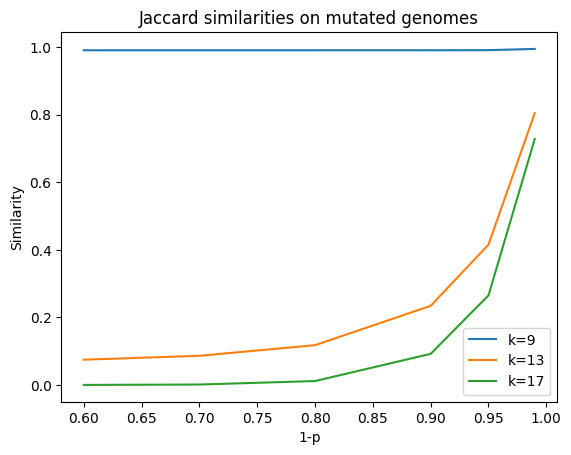

In [95]:
plot_similarities(full_kmer_jaccard_mutated_genome_df, 'Jaccard similarities on mutated genomes', k_list, 'k')

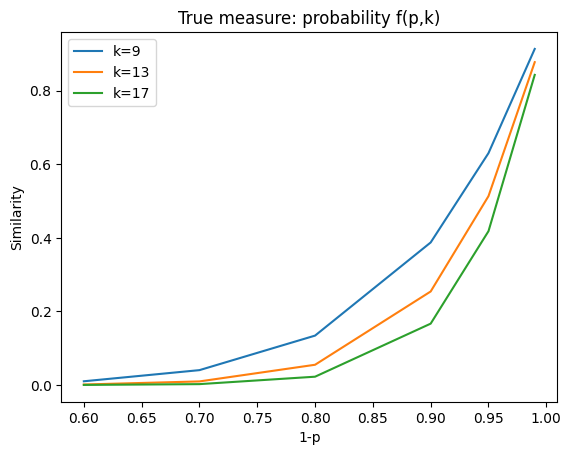

In [96]:
plot_similarities(f_table_df, 'True measure: probability f(p,k)',  k_list, 'k')

### Task 4.4 Discussion

1. Describe how we could estimate $1-p$ from the Jaccard similarity for values of $k$ investigated here using the values you measured or some other calculation you can make.
2. Are some values of $k$ unsuitable (or less suitable) for this purpose? Why is that?
3. In task 3, genome 0 and one other real genome had Jaccard similarity 0.64 for $k=13$. Estimate the percentage of mutated bases between these two real genomes based on this Jaccard similarity.

1 . If we believe that Jaccard similarity is a good estimate of our model
(or that our model is a good estimate of reality
(which isn't entirely true, let's say, because of independence of mutations in neighboring bases)), we can just say

$$j:=J(\mathrm{seq}_1,\mathrm{seq}_2,k) = (1-p)^k,$$

where $J$ is a Jaccard similarity between $\mathrm{seq}_1$ and $\mathrm{seq}_2$.

Well, we choose $k$, also we know Jaccard similarity $j$, so we can solve for $p$:

$$ 1 - p = \sqrt[k]{j}$$
$$ p = 1 - \sqrt[k]{j}$$

2 . We see that $k=9$ is less suitable because it isn't representable: for every $p$ it shows almost $100 \%$ similarity.
It may be caused by small size: only 9-mers may be similar for every bacteria.

3 . So, $p = 1 - \sqrt[13]{0.64} ≈ 1 - 0.9662528040183215 = 0.033747195981678524 ≈0.034 = 3.4\%$

## Task 5: Accuracy of minimizers

Instead of computing Jaccard similarity for the full set of $k$-mers, we can also run it on the set of minimizers. This can be understood as an estimate of the Jaccard similarity on the full set of $k$-mers using a smaller memory. In this task we will compare the accuracy of this estimate to the Jaccard similarity computed for the full set of $k$-mers in Task 4.2, which we consider here as "the correct answer".

1. Compute the similarity of genome 0 to all mutated genomes using $k$=13 and values of $s$=2,5,10 for minimizers. For hash function use `kmer_hash`. Print a table of these values in an easy to read form.
2. Compute the difference between the Jaccard similarity values for $k$=13 from Task 4.2 (using all kmers) and the values from Task 5.1 and print a table of these differences in an easy to read form.
3. Optionally visualize the values using appropriate plots.
4. Discuss your findings. What trends do you see with increasing $s$? What causes these trends? (Explain them based on your understanding of the used algorithms.)

In [68]:
# TODO: you code for computing the values and optionally visualizing them
# you can split the code into multiple cells if you wish

# TODO place the code for computing and printing the distances here
s_list = [2,5,10]

sims_for_s = dict()
for s in s_list:
    similarities = minimizer_jaccard(real_genomes[0], real_genomes[1:], k=13, s=s, h=kmer_hash)
    sims_for_s[s] = similarities

In [85]:
minimizers_jaccard_real_genome_df = pd.DataFrame(sims_for_s |
                                  {'description': real_genome_descriptions[1:]})

minimizers_jaccard_real_genome_df.set_index('description', inplace=True)
minimizers_jaccard_real_genome_df


,2,5,10
description,,,
"NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, complete genome",0.634873,0.624159,0.613582
"NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, complete genome",0.270817,0.254032,0.243267
"NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome",0.053394,0.045917,0.043155
"NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome, complete genome",0.136301,0.119740,0.111912
"NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome",0.578426,0.565851,0.553799
"NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete genome",0.139793,0.122967,0.114922
"NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, complete genome",0.136847,0.120491,0.112504
"NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, complete genome",0.137892,0.121609,0.113665


In [87]:
minimizers_jaccard_real_genome_df[s_list] = minimizers_jaccard_real_genome_df[s_list].sub(
    jaccard_real_genome_df['jaccard_index'], axis=0)

minimizers_jaccard_real_genome_df


,2,5,10
description,,,
"NZ_CP031922.1 Escherichia coli O26:H11 strain FWSEC0001 chromosome, complete genome",-0.008730,-0.019444,-0.030021
"NZ_CP083638.1 Escherichia fergusonii strain FDAARGOS_1499 chromosome, complete genome",-0.016453,-0.033237,-0.044002
"NC_007795.1 Staphylococcus aureus subsp. aureus NCTC 8325 chromosome, complete genome",-0.009143,-0.016620,-0.019382
"NC_016845.1 Klebsiella pneumoniae subsp. pneumoniae HS11286 chromosome, complete genome",-0.017994,-0.034556,-0.042384
"NC_002695.2 Escherichia coli O157:H7 str. Sakai DNA, complete genome",-0.010248,-0.022823,-0.034874
"NZ_CP009756.1 Enterobacter cloacae strain GGT036 chromosome, complete genome",-0.018389,-0.035216,-0.043260
"NZ_AP019632.1 Enterobacter asburiae strain 1808-013 chromosome, complete genome",-0.017778,-0.034134,-0.042120
"NZ_AP022508.1 Enterobacter bugandensis strain STN0717-56 chromosome, complete genome",-0.017865,-0.034147,-0.042092


So, we find out only a little difference between minimizers and full k-mers.

Because minimizers effectivly are counting subsets of all k-mers, it's kind of expectable, that it will underestimate full k-mer similarity by some small number.

Also, while counting minimizers for bigger sliding windows, we get that results tend to differ more, which is because for bigger $s$ difference between size of set of all k-mers and set of minimizers are increasing with increasing $s$.

## Task 6: Running time and memory

1. Measure the running time of computing the $k$-mer sets on genome 0 using functions `full_kmer_set` and `minimizer_set` for parameters $k$ and $s$ as in Task 5 using `kmer_hash` hash function. You can measure time simply using `time.time()` function before and after computation as is done in the downloading genomes section above. This simply measures the wall clock time, not CPU usage. You can also use alternative ways of measuring time.
2. As a proxy for memory consumption, report the size of the sets produced in Task 6.1.
3. List the times and set sizes as easy-to-read tables or appropriate plots.
4. Discuss your findings. How do the parameter values and the choice of algorithm influence the running time and memory? Can you make some recommendations on which method to choose considering all aspects (accuracy, running time and memory)?

In [ ]:
# TODO: you code for measuring time here, optionally also your visualizations
# you can split the code into multiple cells if you wish

**#TODO** Write your discussion here.

## Some additional tests

Please run these tests and do not modify them. They may help you to find errors in your code.

In [120]:
def _check(name, cond, detail=""):
    """Helper to print [OK]/[FAIL] results with extra info."""
    if cond:
        print(f"[OK]   {name}")
    else:
        print(f"[FAIL] {name} x {detail}")


# ---------------------------------------------------------------
# ## Task 1.1 – jaccard
# ---------------------------------------------------------------
A, B = {"x", "y", "z"}, {"y", "z", "w"}
J = jaccard(A, B)
_check("1.1 Jaccard symmetry",
       jaccard(A, B) == jaccard(B, A),
       f"Got {jaccard(A, B)} vs {jaccard(B, A)}")

_check("1.1 Jaccard identical sets = 1",
       jaccard(A, A) == 1.0,
       f"Got {jaccard(A, A)} expected 1.0")

_check("1.1 Jaccard disjoint sets = 0",
       jaccard({'a'}, {'b'}) == 0.0,
       f"Got {jaccard({'a'}, {'b'})} expected 0.0")

_check("1.1 Jaccard range [0,1]",
       0 <= J <= 1,
       f"Got {J}")

# ---------------------------------------------------------------
# ## Task 1.2 – kmer_jaccard
# ---------------------------------------------------------------
s1 = "AAACCCGGGTTTAAACCC"
s2 = "AAACCCGGGTTTAAAGGG"
k = 5
J_expected = jaccard(full_kmer_set(s1, k), full_kmer_set(s2, k))
J_got = kmer_jaccard(s1, [s2], k)[0]
_check("1.2 kmer_jaccard matches direct Jaccard",
       abs(J_expected - J_got) < 1e-3,
       f"Expected {J_expected}, got {J_got}")

# extra bound tests
setA = {'abc'};
setB = {'bb'};
setAB = {'abc', 'bb'}
_check("1.2 Jaccard simple ½",
       jaccard(setA, setAB) == 0.5,
       f"Got {jaccard(setA, setAB)} expected 0.5")

_check("1.2 Jaccard simple ⅓",
       abs(jaccard(setA, {'abc', 'bb', 'cde'}) - 1 / 3) < 1e-3,
       f"Got {jaccard(setA, {'abc', 'bb', 'cde'})} expected ~0.3333")

# ---------------------------------------------------------------
# ## Task 1.3 – small example consistency
# ---------------------------------------------------------------
seq1, seq2, seq3, seq4 = "AAACCC", "GGGTTT", "AAAGTG", "ACAC"
expected = [1.0, 1.0, 1 / 7, 0.0]
got = kmer_jaccard(seq1, [seq1, seq2, seq3, seq4], 3)
_check("1.3 kmer_jaccard example output",
       all(abs(a - b) < 1e-3 for a, b in zip(got, expected)),
       f"Expected {expected}, got {got}")

# ---------------------------------------------------------------
# ## Task 2.1 – minimizer_set
# ---------------------------------------------------------------
exp1 = {'AAA', 'AAC', 'ACG', 'CAA'}
got1 = minimizer_set('AAACGCAAA', 3, 3, debug_hash)
_check("2.1 minimizer_set example #1",
       got1 == exp1,
       f"Expected {exp1}, got {got1}")

exp2 = {'AA', 'AC', 'AG', 'CC'}
got2 = minimizer_set('AAACGCAAAGGGGG', 2, 4, debug_hash)
_check("2.1 minimizer_set example #2",
       got2 == exp2,
       f"Expected {exp2}, got {got2}")

# deterministic output check
s = "AAGGGTTTCCCAAAGGGTTT"
m1 = minimizer_set(s, 3, 4, kmer_hash)
m2 = minimizer_set(s, 3, 4, kmer_hash)
_check("2.1 deterministic output",
       m1 == m2,
       f"Run1 size={len(m1)}, Run2 size={len(m2)}")

# reverse-complement invariance
rcs = _reverse_complement(s)
m_rc = minimizer_set(rcs, 3, 4, kmer_hash)
_check("2.1 RC invariance (k=3,s=4)",
       m1 == m_rc,
       f"Set differences: {m1.symmetric_difference(m_rc)}")

# size monotonicity sanity
base = "ACGTACGTACGTACGTACGTACGTACGTACGT"
for k in [7, 9]:
    sizes = [len(minimizer_set(base, k, s, kmer_hash)) for s in range(2, 7)]
    ok = all(sizes[i] >= sizes[i + 1] for i in range(len(sizes) - 1))
    _check(f"2.1 size non-increasing with s (k={k})", ok, f"Observed sizes={sizes}")

# ---------------------------------------------------------------
# ## Task 2.3 – minimizer_jaccard
# ---------------------------------------------------------------
seq1, seq2, seq3, seq4 = "AAACCC", "GGGTTT", "AAAGTG", "ACAC"
expected = [1.0, 1.0, 2 / 3, 1 / 3]
got = minimizer_jaccard(seq1, [seq1, seq2, seq3, seq4], 2, 2, debug_hash)
_check("2.3 minimizer_jaccard example output",
       all(abs(a - b) < 1e-3 for a, b in zip(got, expected)),
       f"Expected {expected}, got {got}")

# consistency with direct set Jaccard
a = "AAACCCGGGTTTAAACCCGGG"
b = "AAACCCGGGTTTAAACCCGGA"
k, s = 5, 3
J1 = minimizer_jaccard(a, [b], k, s, kmer_hash)[0]
Aset = minimizer_set(a, k, s, kmer_hash)
Bset = minimizer_set(b, k, s, kmer_hash)
J2 = jaccard(Aset, Bset)
_check("2.3 minimizer_jaccard equals J(set)",
       abs(J1 - J2) < 1e-3,
       f"Expected {J2}, got {J1}")

# ---------------------------------------------------------------
# ## Task 2.4 – consistency on real data subset
# ---------------------------------------------------------------
g0 = real_genomes[0][:20000]
g1 = real_genomes[1][:20000]
for k in [9, 13]:
    J_full = jaccard(full_kmer_set(g0, k), full_kmer_set(g1, k))
    for s in [2, 5]:
        J_min = minimizer_jaccard(g0, [g1], k, s, kmer_hash)[0]
        _check(f"2.4 minimizer J ≤ full J (k={k},s={s})",
               J_min <= J_full + 1e-9,
               f"Full={J_full:.4f}, Minimizer={J_min:.4f}")

# ---------------------------------------------------------------
# ## Performance sanity
# ---------------------------------------------------------------
sub = real_genomes[0][:100000]
k = 13
t0 = time.time();
S_full = full_kmer_set(sub, k);
t1 = time.time()
S_min2 = minimizer_set(sub, k, 2, kmer_hash);
t2 = time.time()
S_min5 = minimizer_set(sub, k, 5, kmer_hash);
t3 = time.time()

print(f"\nPerformance sample (100 kbp, k=13)")
print(f" full_kmer_set : {len(S_full):>8} elements in {t1 - t0:.2f}s")
print(f" minimizer s=2 : {len(S_min2):>8} elements in {t2 - t1:.2f}s")
print(f" minimizer s=5 : {len(S_min5):>8} elements in {t3 - t2:.2f}s")

_check("Performance: size order s=5 ≤ s=2 ≤ full",
       len(S_min5) <= len(S_min2) <= len(S_full),
       f"Sizes: full={len(S_full)}, s=2={len(S_min2)}, s=5={len(S_min5)}")

print("\n All tests completed successfully.")
# ===============================================================


[OK]   1.1 Jaccard symmetry
[OK]   1.1 Jaccard identical sets = 1
[OK]   1.1 Jaccard disjoint sets = 0
[OK]   1.1 Jaccard range [0,1]
[OK]   1.2 kmer_jaccard matches direct Jaccard
[OK]   1.2 Jaccard simple ½
[OK]   1.2 Jaccard simple ⅓
[OK]   1.3 kmer_jaccard example output
[OK]   2.1 minimizer_set example #1
[OK]   2.1 minimizer_set example #2
[OK]   2.1 deterministic output
[OK]   2.1 RC invariance (k=3,s=4)
[OK]   2.1 size non-increasing with s (k=7)
[OK]   2.1 size non-increasing with s (k=9)
[OK]   2.3 minimizer_jaccard example output
[OK]   2.3 minimizer_jaccard equals J(set)
[OK]   2.4 minimizer J ≤ full J (k=9,s=2)
[OK]   2.4 minimizer J ≤ full J (k=9,s=5)
[OK]   2.4 minimizer J ≤ full J (k=13,s=2)
[OK]   2.4 minimizer J ≤ full J (k=13,s=5)

Performance sample (100 kbp, k=13)
 full_kmer_set :    99266 elements in 0.28s
 minimizer s=2 :    66104 elements in 0.81s
 minimizer s=5 :    33089 elements in 0.82s
[OK]   Performance: size order s=5 ≤ s=2 ≤ full

 All tests completed su